# Can we predict whether a player subscribes based on their age?

# Introduction:






# Methods & Results:

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

In [6]:
players <- read_csv("https://raw.githubusercontent.com/calentynes/dsci_group_project/refs/heads/master/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/calentynes/dsci_group_project/refs/heads/master/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



# Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to
  
# References

You may include references if necessary, as long as they all have a consistent citation style.

Combining two datasets together:

In [7]:
sessions <- sessions |>
  mutate(session_length = as.numeric(difftime(end_time, start_time, units = "hours")))
player_summary <- sessions |>
  group_by(hashedEmail) |>
  summarize(
    total_sessions = n(),
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_play_time = sum(session_length, na.rm = TRUE))
player_data <- players |>
  left_join(player_summary, by = "hashedEmail")

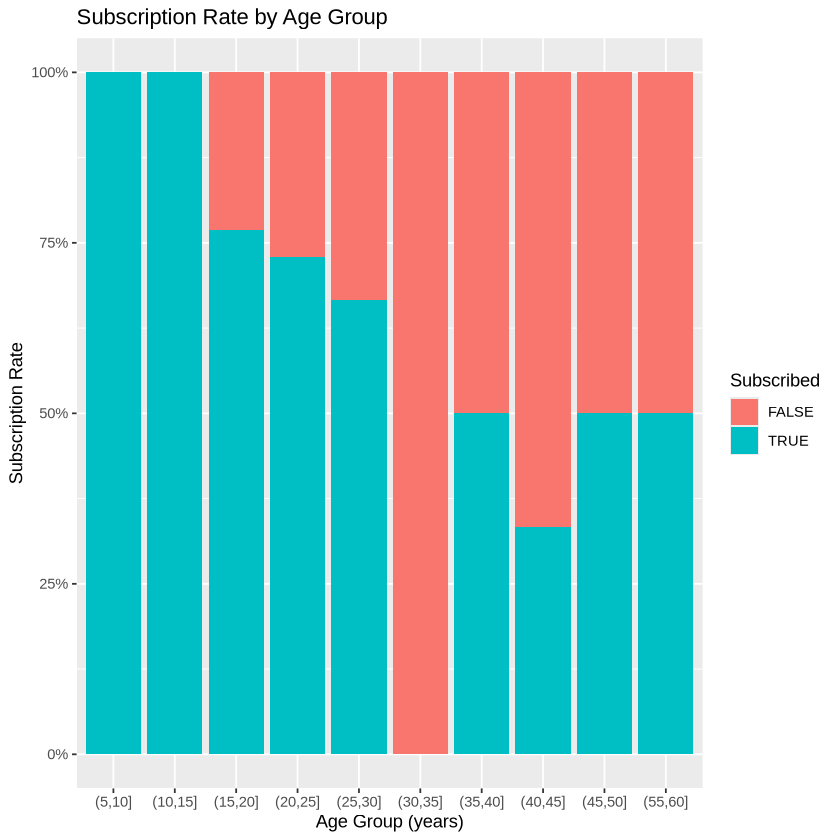

In [9]:
players_clean <- players |> filter(!is.na(subscribe))
p_age <- players_clean |>
  filter(!is.na(Age)) |>
  mutate(age_group = cut(Age, breaks = seq(5, 60, by = 5), right = TRUE)) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  labs(title = "Subscription Rate by Age Group",
       x = "Age Group (years)", y = "Subscription Rate",
       fill = "Subscribed")
p_age